In [ ]:
# 1) Quick GPU check
!nvidia-smi || true

# 2) Install core packages
# Note: diffusers requires recent versions of torch + transformers; this installs the common stack.
!pip -q install -U "diffusers[torch]" transformers accelerate safetensors huggingface_hub

# 3) Optional helpers (may fail on some Colab setups; ok to ignore failure)
!pip -q install -U "xformers" || echo "xformers failed to install (not required)."

# 4) small utility libs
!pip -q install -U pillow einops


Wed Sep 24 07:05:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Interactive login: this will prompt you to paste your Hugging Face token
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"   # good general-purpose model

# Load in half precision to save memory (float16) if GPU supports it
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,       # optional: set to None to skip HF safety checker (be careful)
)

# Move to GPU
if torch.cuda.is_available():
    pipe = pipe.to("cuda")
else:
    pipe = pipe.to("cpu")  # will be slow on CPU

# Helpful memory optimizations (safe to call even if xformers not available)
pipe.enable_attention_slicing()  # lowers memory peak
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception:
    pass

print("Pipeline ready. Device:", next(pipe.unet.parameters()).device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Pipeline ready. Device: cuda:0


  0%|          | 0/30 [00:00<?, ?it/s]

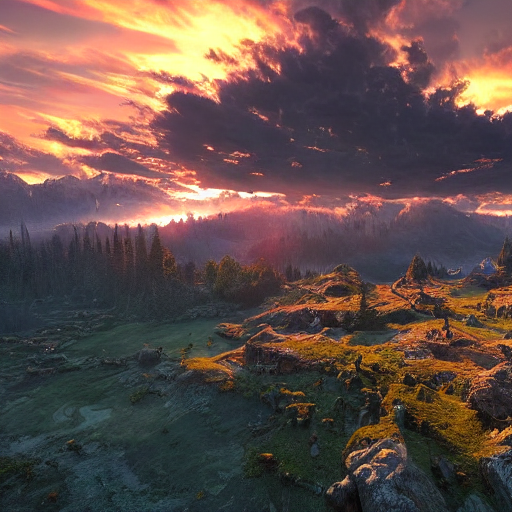

In [ ]:
from torch import autocast
import torch
from PIL import Image
from IPython.display import display

prompt = "A majestic fantasy landscape, sunset, ultra-detailed, cinematic lighting, 4k"
seed = 1024
generator = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu").manual_seed(seed)

# Use autocast to reduce memory when using float16
device_type = "cuda" if torch.cuda.is_available() else "cpu"
with autocast(device_type):
    result = pipe(
        prompt,
        guidance_scale=7.5,          # classifier-free guidance strength (higher = closer to prompt)
        num_inference_steps=30,     # more steps = finer detail, but slower
        height=512,
        width=512,
        generator=generator
    )

image = result.images[0]
image.save("generated.png")
display(image)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

out_0.png


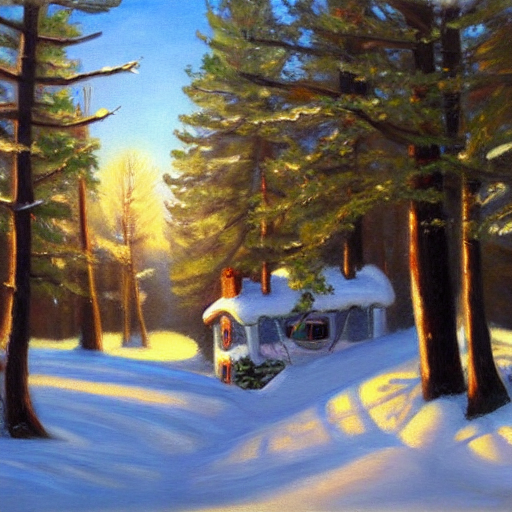

out_1.png


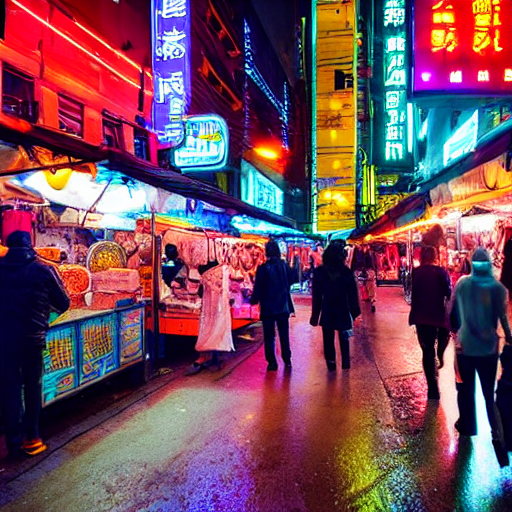

In [ ]:
prompts = [
    "A cozy cottage in a snowy forest, oil painting, warm light, high detail",
    "A cyberpunk street market at night, neon signs, rain, cinematic"
]

negative_prompt = "low quality, blurry, watermark, text, artifacts"

images = []
for i, p in enumerate(prompts):
    gen = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu").manual_seed(1000 + i)
    with autocast("cuda" if torch.cuda.is_available() else "cpu"):
        out = pipe(
            p,
            negative_prompt=negative_prompt,
            guidance_scale=8.0,
            num_inference_steps=30,
            generator=gen
        )
    img = out.images[0]
    fname = f"out_{i}.png"
    img.save(fname)
    images.append((fname, img))

for fname, img in images:
    print(fname)
    display(img)


In [ ]:
# Small UI so you can try prompts interactively
!pip -q install -U gradio

import gradio as gr

def gen_image(prompt, guidance_scale=7.5, steps=30, seed=42):
    gen = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu").manual_seed(int(seed))
    with autocast("cuda" if torch.cuda.is_available() else "cpu"):
        out = pipe(prompt, guidance_scale=float(guidance_scale), num_inference_steps=int(steps), generator=gen)
    return out.images[0]

demo = gr.Interface(
    fn=gen_image,
    inputs=[
        gr.Textbox(label="Prompt", value="A beautiful fantasy landscape, sunset, ultra-detailed"),
        gr.Slider(minimum=1, maximum=15, value=7.5, label="guidance_scale"),
        gr.Slider(minimum=1, maximum=100, value=30, label="steps"),
        gr.Number(value=42, label="seed")
    ],
    outputs=gr.Image(type="pil"),
    title="Text→Image demo (Stable Diffusion)"
)

demo.launch(share=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 15.4 MB/s eta 0:00:00
